# Make token vocabulary
Train a tokenizer on the Tira ASR dataset

In [187]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from transformers import WhisperTokenizer
import pandas as pd
import numpy as np
import seaborn
import string

In [88]:
metadata='/Users/markjos/projects/malachor5/data/tira-clean/metadata.csv'

In [89]:
unk = "[UNK]"
trainer=trainers.WordPieceTrainer(vocab_size=800, special_tokens=[unk])

In [90]:
df=pd.read_csv(metadata)
def get_text_corpus():
    for row in df['transcription']:
        yield row

In [91]:
tokenizer = Tokenizer(models.WordPiece(unk_token=unk))
tokenizer.train_from_iterator(get_text_corpus(), trainer=trainer)

In [92]:
line=df['transcription'][5000]
encoding=tokenizer.encode(line)

line, encoding.tokens, encoding.ids

('là t̪ə́rvàvɛ̀',
 ['là ', '##t̪', '##ə́r', '##v', '##àv', '##ɛ̀'],
 [477, 94, 479, 49, 312, 87])

In [128]:
tira_vocab=tokenizer.get_vocab()
vocab_lens=[]
for item in tira_vocab:
    vocab_lens.append(len(item.strip().replace('#', '')))
np.array(vocab_lens).mean()

4.44875

In [130]:
tira_id2tok={v:k for k, v in tira_vocab.items()}

In [94]:
tira_ids=df['transcription'].apply(lambda s: tokenizer.encode(s).ids)
tira_tokenized=df['transcription'].apply(lambda s: tokenizer.encode(s).tokens)
tira_tokenized, tira_ids

(0                         [lə̀və̀lɛ̀ð, ##ɛ́l , ##únɛ̀ɾɛ̀]
 1                            [kə̀, ##ŋà, ##c, ##î, ##í]
 2              [ŋ̀g, ##átɛ́, ##və́lɛ̂ðɔ́ nd̪ɔ̀bà, ##gɛ̀]
 3        [ŋ, ##ɔ́ð, ##ɔ́ ŋ, ##á , ##və́lɛ̀ðà ð, ##àŋ...
 4                          [ðə̀, ##və̀l, ##è, ##ðɔ̀, ##ŋ]
                                ...                        
 20475    [ðá , ##nɛ́, ##l, ##ê, ## , ##və̀lɛ̀ðɔ́ nd̪ɔ...
 20476                                    [ŋ, ##ə̀v, ##rà]
 20477       [ŋ, ##ə̀, ##bú, ##r, ##ŋ, ##ɛ̀ , ##án, ##ó]
 20478    [lá , ##vŕ, ##ð, ##ìt̪, ##ɔ̀ , ##ku, ##ku, ...
 20479    [ùrnɔ̀ , ##kə̀, ##ŋ, ##a, ##cí , ##ápr, ##i...
 Name: transcription, Length: 20480, dtype: object,
 0                                          [394, 517, 280]
 1                                 [359, 211, 73, 255, 100]
 2                                     [526, 569, 675, 199]
 3                  [25, 697, 149, 111, 518, 157, 564, 108]
 4                                 [561, 136, 13

In [95]:
tokenized_corpus_concat=np.concatenate(tira_tokenized)
tokenized_corpus_concat.shape

(142409,)

In [185]:
token_counts=pd.Series(tokenized_corpus_concat).value_counts()
token_counts[token_counts>=100]

##            2706
##ŋ           1983
##r           1572
##nd̪ɔ̀bà    1470
##n           1406
              ... 
##wà          100
##cí ŋ        100
##rí          100
ág            100
##ɛ́l          100
Name: count, Length: 438, dtype: int64

In [186]:
pd.Series(tokenized_corpus_concat).unique().shape

(791,)

# Get predicted Whisper tokens
Run Whisper tokenizer on transcribed Tira ASR dataset

In [98]:
whisper_labels = '/Users/markjos/projects/malachor5/data/tira-asr/tira-clean-split-transcribed.csv'

whisper_df=pd.read_csv(whisper_labels)
whisper_df.head()

,path,croatian,split
0,HH01082021-m03s37ms011-m03s39ms552.wav,A prije jedi za hala.,train
1,HH01082021-m03s41ms371-m03s45ms023.wav,Apri-jadi-vanhala.,train
2,HH01082021-m04s43ms401-m04s46ms528.wav,A prije je vledo da hvala.,train
3,HH01082021-m04s48ms835-m04s51ms580.wav,A prije je vledo za hala.,train
4,HH01082021-m05s04ms737-m05s07ms762.wav,Apre je vledo za mala.,train


First, let's merge the Whisper and Tira metadata

In [99]:
df.shape, whisper_df.shape

((20480, 29), (20480, 3))

In [100]:
df_merge=pd.merge(df, whisper_df, on='path')
df_merge.shape

(20480, 31)

In [110]:
# df_merge.to_csv(metadata, index=False)

In [109]:
df['split']=df['split_x']
df['croatian']=df['croatian_x']
df=df.drop(['split_x', 'split_y', 'croatian_x', 'croatian_y'], axis=1)
df.columns

Index(['start', 'end', 'transcription', 'eaf_source', 'wav_source',
       'raw_transcription', 'clip', 'wav_rawpath', 'file_name', 'path',
       'allosaurus', 'clap_ipa_cos_sim', 'wada_snr', 'nist_stnr',
       'speaker-diarization-3.1', 'voice-activity-detection',
       'whisper-large-v3', 'clapipa-transcription-allosaurus', 'vad_s',
       'drz_s', 'trans_len', 'pcnt_speech', 'trans_len_sq', 'trans_len_log',
       'cos_sim_softmax', 'cos_sim_log', 'duration', 'split', 'croatian'],
      dtype='object')

In [112]:
df=pd.read_csv(metadata)

Now let's get Whisper tokens

In [113]:
wh_tok=WhisperTokenizer.from_pretrained('openai/whisper-large-v3')

In [188]:
remove_punct = lambda s: ''.join(c for c in s if c not in string.punctuation)
croatian_ids=df['croatian']\
    .str.lower()\
    .apply(remove_punct)\
    .apply(lambda s: wh_tok.encode(s, add_special_tokens=False))
croatian_ids

0                                      [287, 73, 836, 706]
1                                     [444, 64, 22392, 72]
2        [220, 273, 6908, 1506, 371, 73, 2032, 44254, 1...
3        [45843, 3080, 297, 3680, 779, 1506, 1120, 710,...
4                                    [710, 85, 20336, 298]
                               ...                        
20475               [1120, 408, 20445, 84, 375, 360, 9120]
20476                                         [5947, 4481]
20477                             [14828, 297, 432, 19816]
20478    [635, 331, 1479, 1506, 281, 1571, 350, 378, 34...
20479          [4038, 1771, 444, 64, 10236, 72, 1882, 470]
Name: croatian, Length: 20480, dtype: object

In [189]:
croatian_tokenized=croatian_ids.apply(wh_tok.convert_ids_to_tokens)
croatian_tokenized

0                                          [Ġl, j, ub, av]
1                                         [Ġkn, a, ĠÄį, i]
2                   [Ġ, nd, ati, Ġje, Ġv, j, ero, jat, no]
3        [Ġngo, vo, Ġn, ga, vel, Ġje, Ġda, Ġz, an, ad, ...
4                                         [Ġz, v, lez, om]
                               ...                        
20475                   [Ġda, Ġne, Ġlev, u, Ġli, Ġdo, bro]
20476                                          [Ġnav, rat]
20477                                 [Ġbor, Ġn, ge, Ġano]
20478     [Ġla, ver, de, Ġje, Ġto, go, Ġk, od, ir, ava, o]
20479                    [Ġur, no, Ġkn, a, Äį, i, Ġap, ri]
Name: croatian, Length: 20480, dtype: object

In [140]:
croatian_tk_concat=np.concatenate(croatian_tokenized)
croatian_tk_concat.shape

(257589,)

In [141]:
pd.Series(croatian_tk_concat).value_counts()

.        15875
,        12673
Ġu        8106
v         7177
j         6583
         ...  
edor         1
ahr          1
late         1
bek          1
Ġvere        1
Name: count, Length: 2549, dtype: int64

Let's make a list of only the Whisper tokens that are used and map their ids to their index in the list

In [149]:
croatian_i2whisper_tok=pd.Series(croatian_tk_concat).unique()
croatian_i2whisper_tok_id=pd.Series(np.concatenate(croatian_ids)).unique()
croatian_i2whisper_tok.shape, croatian_i2whisper_tok_id.shape

((2549,), (2549,))

In [152]:
croatian_i2whisper_tok[2548], croatian_i2whisper_tok_id[2548]

('Ġvere', 16443)

In [155]:
whisper_tok_id2croatian_i={v:i for i,v in enumerate(croatian_i2whisper_tok_id)}

In [156]:
croatian_i_shrunk=croatian_ids.apply(
    lambda l:[whisper_tok_id2croatian_i[i] for i in l]
)
croatian_i_shrunk

0                                          [0, 1, 2, 3, 4]
1                                   [5, 6, 7, 6, 8, 9, 10]
2                   [11, 12, 13, 14, 15, 1, 16, 17, 18, 4]
3        [19, 20, 21, 22, 23, 24, 14, 25, 26, 27, 28, 2...
4                                      [26, 32, 33, 34, 4]
                               ...                        
20475                [25, 21, 74, 612, 52, 47, 36, 204, 4]
20476                                        [640, 411, 4]
20477                               [1175, 22, 81, 597, 4]
20478    [110, 1165, 487, 14, 30, 430, 5, 128, 469, 290...
20479           [355, 18, 5, 6, 7, 6, 8, 59, 10, 356, 338]
Name: croatian, Length: 20480, dtype: object

Plop in code from `token_alignment.ipynb`

In [157]:
def get_prob_tensors(ipa_seqs, whisper_seqs):
    ipa_vocab_size = np.max(np.concatenate(ipa_seqs))+1
    whisper_vocab_size = np.max(np.concatenate(whisper_seqs))+1

    eps=1e-8 # avoid division by zero
    sum_sqd_dist = np.full([whisper_vocab_size, ipa_vocab_size], eps)
    ipa_token_counts = np.full(ipa_vocab_size, eps)
    return sum_sqd_dist, ipa_token_counts

def initialize_probs(ipa_seqs, whisper_seqs, sum_sqd_dist, ipa_token_counts):
    for ipa_seq, whisper_seq in zip(ipa_seqs, whisper_seqs):
        for i, ipa_token in enumerate(ipa_seq):
            ipa_token_counts[ipa_token]+=1
            for j, whisper_token in enumerate(whisper_seq):
                i_relative=i/len(ipa_seq)
                j_relative=j/len(whisper_seq)
                sum_sqd_dist[whisper_token,ipa_token]+=(i_relative-j_relative)**2
    prob_unnorm = sum_sqd_dist/(ipa_token_counts)
    sum_prob_unnorm = prob_unnorm.sum(axis=0)
    prob_norm=prob_unnorm/sum_prob_unnorm
    return prob_norm

In [159]:
sum_sqd_dist, ipa_token_counts = get_prob_tensors(tira_ids, croatian_i_shrunk)
sum_sqd_dist.shape, ipa_token_counts.shape

((2549, 800), (800,))

In [161]:
prob_mat=initialize_probs(tira_ids, croatian_i_shrunk, sum_sqd_dist, ipa_token_counts)

<Axes: >

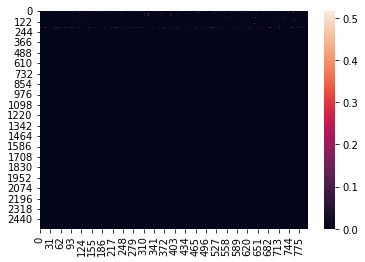

In [164]:
seaborn.heatmap(prob_mat)

In [170]:
max_whisper_tokens=np.argmax(prob_mat, axis=0)

In [184]:
i=50
croatian_i2whisper_tok[max_whisper_tokens[i]], tira_id2tok[i]

('Ġu', '##ə')